In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

/home/chams/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-08-30 06:53:25.413744: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 06:53:25.414927: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-30 06:53:25.501753: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-30 06:53:25.854209: I tensorflow/cor

In [2]:
# Set these values to show/hide certain vectors of the estimation
draw_gaze = True
draw_full_axis = True
draw_headpose = True

# Gaze Score multiplier (Higher multiplier = Gaze affects headpose estimation more)
x_score_multiplier = 4
y_score_multiplier = 4

# Threshold of how close scores should be to average between frames
threshold = .3

# Gaze scores from the previous frame
last_lx, last_rx = 0, 0
last_ly, last_ry = 0, 0



In [3]:
data = np.load("MultiMatrix.npz")

camMatrix = data["camMatrix"]
distCof = data["distCoef"]

print("loaded calibration data successfully")

loaded calibration data successfully


In [4]:
camMatrix

array([[895.07101587,   0.        , 247.87265042],
       [  0.        , 892.0337803 , 140.51830804],
       [  0.        ,   0.        ,   1.        ]])

In [5]:
face_3d = np.array([
    [0.0, 0.0, 0.0],            # Nose tip
    [0.0, -330.0, -65.0],       # Chin
    [-225.0, 170.0, -135.0],    # Left eye left corner
    [225.0, 170.0, -135.0],     # Right eye right corner
    [-150.0, -150.0, -125.0],   # Left Mouth corner
    [150.0, -150.0, -125.0]     # Right mouth corner
    ], dtype=np.float64)

# Reposition left eye corner to be the origin
leye_3d = np.array(face_3d)
leye_3d[:,0] += 225
leye_3d[:,1] -= 170
leye_3d[:,2] += 135

# Reposition right eye corner to be the origin
reye_3d = np.array(face_3d)
reye_3d[:,0] -= 225
reye_3d[:,1] -= 170
reye_3d[:,2] += 135

In [6]:
leye_3d

array([[ 225., -170.,  135.],
       [ 225., -500.,   70.],
       [   0.,    0.,    0.],
       [ 450.,    0.,    0.],
       [  75., -320.,   10.],
       [ 375., -320.,   10.]])

In [7]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False,
    refine_landmarks=True,
    min_detection_confidence=0.5
                    ,max_num_faces=2)

I0000 00:00:1724981008.417241    5045 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1724981008.437020    5205 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) Graphics (ADL GT2)


In [8]:
ex= plt.imread('pexels-simon-robben-55958-614810.jpg')


(img_h, img_w, img_c) = ex.shape
face_2d = []

result= face_mesh.process(ex)
for face_landmarks in result.multi_face_landmarks:
    face_2d = []
    for idx, lm in enumerate(face_landmarks.landmark):
            # Convert landmark x and y to pixel coordinates
        x, y = int(lm.x * img_w), int(lm.y * img_h)

            # Add the 2D coordinates to an array
        face_2d.append((x, y))

face_2d= np.array(face_2d)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1724981008.453635    5117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724981008.469293    5123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/chams/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


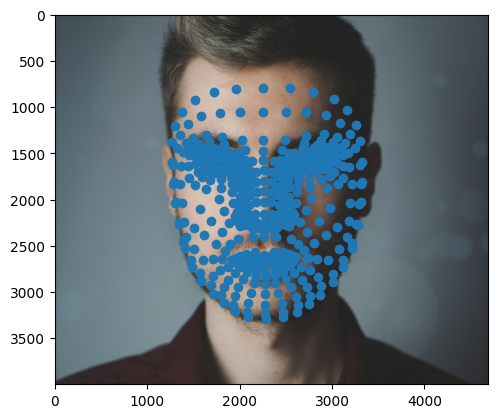

In [9]:
plt.imshow(ex)
plt.scatter(face_2d[:,0],face_2d[:,1])

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    success, img = cap.read()

    # Flip + convert img from BGR to RGB
    img = cv2.cvtColor(cv2.flip(img, 1), cv2.COLOR_BGR2RGB)

    # To improve performance
    img.flags.writeable = False
    
    # Get the result
    results = face_mesh.process(img)
    img.flags.writeable = True
    
    # Convert the color space from RGB to BGR
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    (img_h, img_w, img_c) = img.shape

    if not results.multi_face_landmarks:
      continue 

    for face_landmarks in results.multi_face_landmarks:
        face_2d = []
        for idx, lm in enumerate(face_landmarks.landmark):
            # Convert landmark x and y to pixel coordinates
            x, y = int(lm.x * img_w), int(lm.y * img_h)

            # Add the 2D coordinates to an array
            face_2d.append((x, y))
        
        # Get relevant landmarks for headpose estimation
        face_2d_head = np.array([
            face_2d[1],      # Nose
            face_2d[199],    # Chin
            face_2d[33],     # Left eye left corner
            face_2d[263],    # Right eye right corner
            face_2d[61],     # Left mouth corner
            face_2d[291]     # Right mouth corner
        ], dtype=np.float64)

        face_2d = np.asarray(face_2d)


      
        

    focal_length = 1 * img_w
    cam_matrix = np.array([ [focal_length, 0, img_h / 2],
                            [0, focal_length, img_w / 2],
                                [0, 0, 1]])

        # Distortion coefficients 
    dist_coeffs = np.zeros((4, 1), dtype=np.float64)
    #     # Solve PnP
  
    _, rvec, tvec = cv2.solvePnP(face_3d, face_2d_head, cam_matrix, dist_coeffs)



        # Get rotational matrix from rotational vector

    rmat, _ = cv2.Rodrigues(rvec)

       

        # [0] changes pitch
        # [1] changes roll
        # [2] changes yaw
        # +1 changes ~45 degrees (pitch down, roll tilts left (counterclockwise), yaw spins left (counterclockwise))

        # --- Projection ---

        # Get left eye corner as integer

    nose = face_2d_head[0].astype(np.int32)

        # Project axis of rotation for left eye
    axis = np.float32([[-100, 0, 0], [0, 100, 0], [0, 0, 300]]).reshape(-1, 3)
    # if not np.any(np.isnan(l_rvec)) and not np.any(np.isnan(l_tvec)):
    n_axis, _ = cv2.projectPoints(axis, rvec, tvec, cam_matrix, dist_coeffs)


        # Draw axis of rotation for left eye
    cv2.line(img, nose, tuple(np.ravel(n_axis[0]).astype(np.int32)), (200,200,0), 3)
    cv2.line(img, nose, tuple(np.ravel(n_axis[1]).astype(np.int32)), (0,200,0), 3)
    cv2.line(img, nose, tuple(np.ravel(n_axis[2]).astype(np.int32)), (0,200,200), 3)


 

    cv2.imshow('Head Pose Estimation', img)

    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



    

array([[ 0.99128204,  0.0570443 , -0.11876813],
       [ 0.112594  , -0.83491295,  0.53874202],
       [-0.06842889, -0.54741787, -0.83405705]])

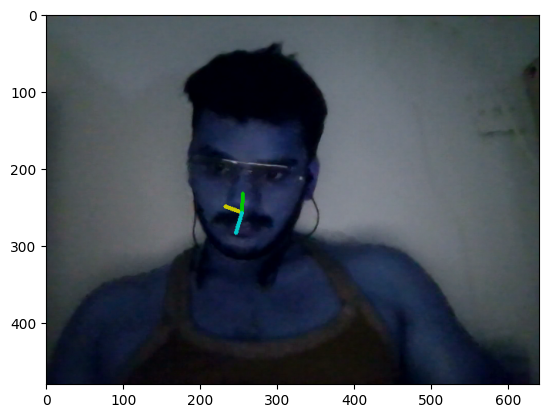

In [13]:
plt.imshow(img)
rmat

In [16]:
# Invert the rotation matrix
rotation_matrix_inv = np.transpose(rmat)

# Add translation (assuming no translation, so it's zero)
translation_vector = np.zeros((3, 1))

# Create the 3x3 transformation matrix for cv2.warpPerspective
# Here, we augment the 3x3 inverse rotation matrix with a translation vector to form a 3x4 matrix
transformation_matrix = np.hstack((rotation_matrix_inv, translation_vector))

# Since warpPerspective requires a 3x3 matrix, we need to convert this 3x4 matrix
# into a valid 3x3 matrix that can be used to transform the image.
# This part will simulate a projection, but without depth (2D to 2D transformation).
perspective_matrix = transformation_matrix[:3, :3].astype(np.float32)

# Now you can apply the transformation to your image
height, width = img.shape[:2]

# Apply the perspective warp (3x3 matrix) to the image
transformed_image = cv2.warpPerspective(img, perspective_matrix, (width, height))



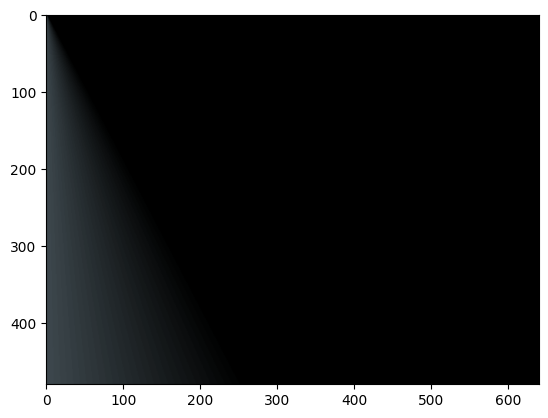

In [17]:
plt.imshow(transformed_image)

In [19]:
transformed_image


array([[[20, 28, 30],
        [ 1,  1,  1],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[60, 81, 88],
        [20, 28, 30],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[63, 80, 87],
        [31, 40, 44],
        [ 2,  3,  3],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[62, 73, 78],
        [62, 73, 78],
        [60, 70, 76],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[62, 73, 78],
        [62, 73, 78],
        [60, 70, 76],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[62, 73, 78],
        [62, 73, 78],
        [60, 70, 76],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)